# Import Libraries

In [0]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Bidirectional, LSTM
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Check for TPU

In [0]:
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.7.246.18:8470


# Load Data

Download Data from Google Drive

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1l6EHtc6hy2VrwLZGX0APpV09L11y2B4q' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: @NQ_Daily.txt, id: 1lNJ2Axp0utKI8d0lvWpKAaRptqjX5WNq
downloading to /root/data/@NQ_Daily.txt


In [0]:
def load_data(data, seq_len, all_data):
    sequence_length = seq_len + 1
    result = []
    
    # Turn dataset into time-series
    for index in range(len(data) - sequence_length + 1):
        result.append(data[index: index + sequence_length, :])
    
    result = np.array(result)
    # Pre-standardized Data
    original_data = result.copy()
    
    # Standardize Data
    result, scalars = standardize_windows(result)
    result = np.array(result)
    
    # Split into Training and Test Sets
    row = round(0.8 * result.shape[0])
    train_result = shuffle(result[:int(row),:,:])
    x_train = train_result[:, :-1, :]
    y_train = train_result[:, -1, 3]
    x_test = result[int(row):, :-1, :]
    y_test = result[int(row):, -1, 3]
    original_data = original_data[int(row):, -1, 3]
    dates = all_data['Date'].values[int(row)+seq_len:]
    
    return [x_train, y_train, x_test, y_test, scalars, original_data, dates]

## Standaradize Data

In [0]:
def standardize_windows(window_data):
    standardized_data = []
    scalar = []
    i = 0
    for window in window_data:
        scalar.append(StandardScaler())
        scalar[i].fit(window[:-1])
        standardized_window = scalar[i].transform(window)
        standardized_data.append(standardized_window)
        i += 1
    return standardized_data, scalar

# Helper Functions

## Create Model

In [0]:
def create_model(data):
  
  input_data = tf.keras.Input(shape=(data.shape[1], data.shape[2]))

  x = Bidirectional(LSTM(32, return_sequences=True))(input_data)

  x = Bidirectional(LSTM(32, return_sequences=True))(x)

  x = Bidirectional(LSTM(32, return_sequences=True))(x)

  x = Bidirectional(LSTM(32, return_sequences=True))(x)

  x = Bidirectional(LSTM(32, return_sequences=False))(x)

  x = Dense(1, activation='linear')(x)

  model = tf.keras.Model(input_data, x)

  opt = tf.train.AdamOptimizer()

  model.compile(loss='mse', optimizer=opt)
  
  model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

  model.summary()
  
  return model

## Plot Loss

In [0]:
def plot_loss(history):
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

## Transform Values into Directional Data

In [0]:
def directional_data(data, original_data):
    result = []
    x = 0
    y = 0
    z = 0
    for j in range(1,len(data)):
        i = j
        if abs(data[i]-original_data[i-1]) < (0.3/100*original_data[i-1]):
            result.append([0,1,0])
            x = x+1
        elif data[i] > original_data[i-1]:
            result.append([0,0,1])
            y = y+1
        else:
            result.append([1,0,0])
            z = z+1
    print("No change: " + str(x))
    print("Up: " + str(y))
    print("Down: " + str(z))
    result = np.array(result)
    return result

## Plot Results

In [0]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

## Plot Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ["Down", "No Change", "Up"]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    mpl.rcParams['axes.grid'] = False
    fig, ax = plt.subplots(1,1, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.show
    return ax

# Experiments


## Define Constants and Load Data

In [0]:
epochs  = 100
seq_len = 30

with open(fname, 'r') as f:
  all_data = pd.read_csv(f, sep=',')
df = all_data.drop(["Date","Time", "OpenBar", "FLS"], axis=1)

## First Half

### Load Data

In [0]:
x_train, y_train, x_test, y_test, scalars, original_data, dates = load_data(df.values[:int(len(df)/2)], seq_len, all_data[:int(len(df)/2)])

TPU = 8

index = int(x_test.shape[0]/TPU)*TPU
x_test = x_test[:index,:,:]
y_test = y_test[:index]
original_data = original_data[:index]
dates = dates[:index]

print(x_train.shape)
print(y_train.shape)

(1827, 30, 16)
(1827,)


### Create Model

In [0]:
model = create_model(x_train)

INFO:tensorflow:Querying Tensorflow master (grpc://10.7.246.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 7456853519070713707)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14558934335835245626)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7541544238226734802)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15440706205147677990)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 17528447551500237016)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

### Train Model

In [0]:
callbacks_list = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
]

history = model.fit(x_train,
                    y_train,
                    batch_size=60*TPU,
                    epochs=5000,
                    shuffle=True,
                    callbacks=callbacks_list,
                    validation_split=0.1,
                    verbose=1)

model.save('bi_lstm_first_half.h5')

Train on 1827 samples, validate on 183 samples
Epoch 1/5000
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(60,), dtype=tf.int32, name='core_id_60'), TensorSpec(shape=(60, 30, 16), dtype=tf.float32, name='input_4_10'), TensorSpec(shape=(60, 1), dtype=tf.float32, name='dense_3_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_4
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 158.80647921562195 secs
INFO:tensorflow:Setting weights on TPU model.
 960/1827 [==============>...............] - ETA: 4:31 - loss: 2.1584 INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(48,), dtype=tf.int32, name='core_id_60'), TensorSpec(shape=(48, 30, 16), dtype=tf.float32, name='input_4_10'), TensorSpec(shape=(48, 1), dtype=tf.float32, name='dense_3_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflo

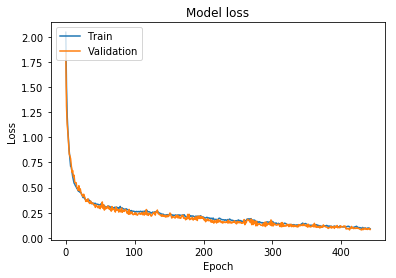

In [0]:
plot_loss(history)

### Predict for Test Set

In [0]:
predicted = model.predict(x_test)

INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(4, 30, 16), dtype=tf.float32, name='input_4_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_4
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 350.3678889274597 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(1, 30, 16), dtype=tf.float32, name='input_4_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_4
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 195.2763864994049 secs


### Rescale Data

In [0]:
new_predicted = []

for i in range(len(predicted)):
  temp = np.zeros((x_train.shape[2],))
  # 3 for closing price
  temp[3] = predicted[i]
  new_predicted.append(scalars[len(x_train)+i].inverse_transform(temp)[3])
  
predicted = np.array(new_predicted)

### Plot Predictions

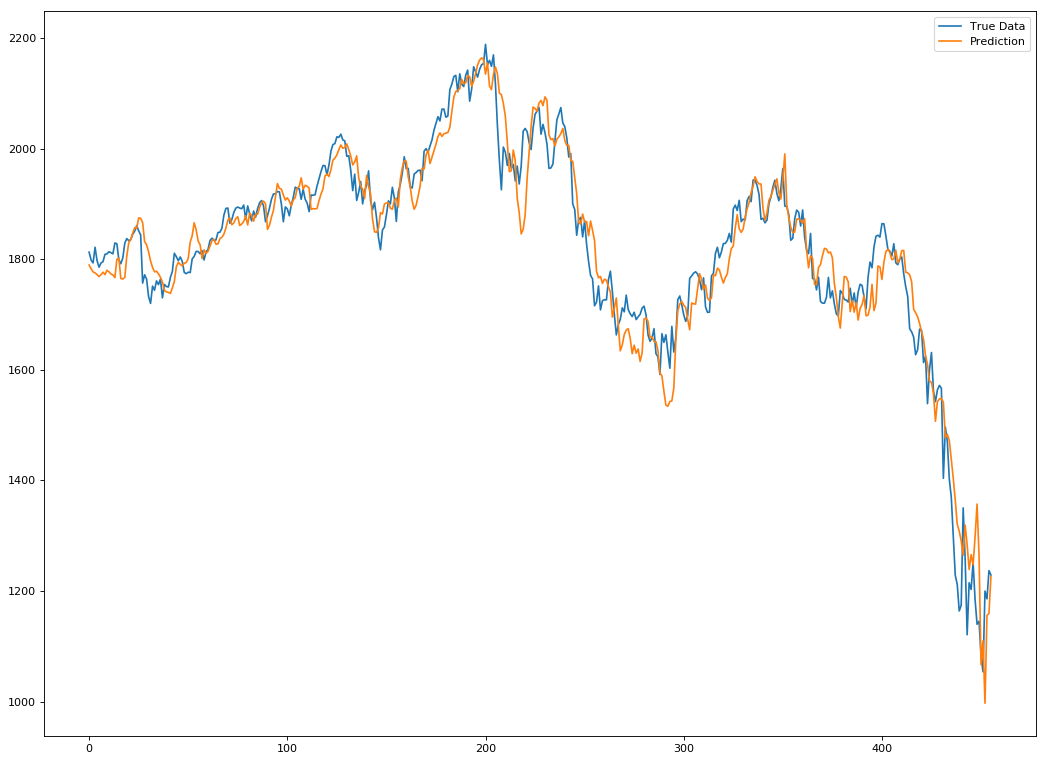

In [0]:
plot_results(predicted, original_data)

### Mean Squared Error

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(predicted, original_data)

2392.228090154434

### Mean Absolute Percentage Error



In [0]:
print(np.mean(np.abs((original_data - predicted) / original_data)) * 100)

2.089310756881415


### Convert to Directional Data

In [0]:
predicted_directions = directional_data(predicted, original_data)

No change: 84
Up: 155
Down: 216


In [0]:
actual_directions = directional_data(original_data, original_data)

No change: 126
Up: 166
Down: 163


### Plot Confusion Matrix

In [0]:
classes = ["Down", "No Change", "Up"]
classes = np.array(classes)

indices = predicted_directions.argmax(axis=1)
predicted_classes = classes[indices]

indices = actual_directions.argmax(axis=1)
y_true = classes[indices]

By Count

Confusion matrix, without normalization
[[79 29 55]
 [64 27 35]
 [73 28 65]]


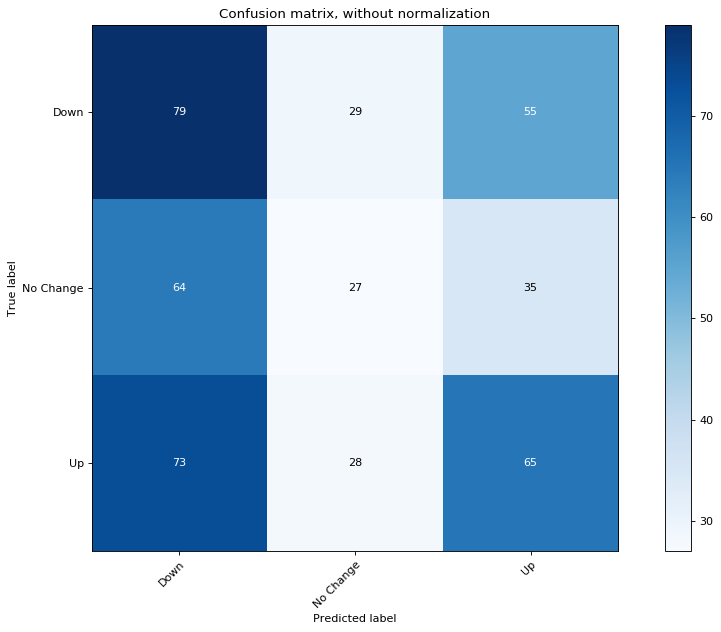

In [0]:
plot_confusion_matrix(y_true, predicted_classes, normalize=False)

Normalized

Normalized confusion matrix
[[0.48466258 0.17791411 0.33742331]
 [0.50793651 0.21428571 0.27777778]
 [0.43975904 0.1686747  0.39156627]]


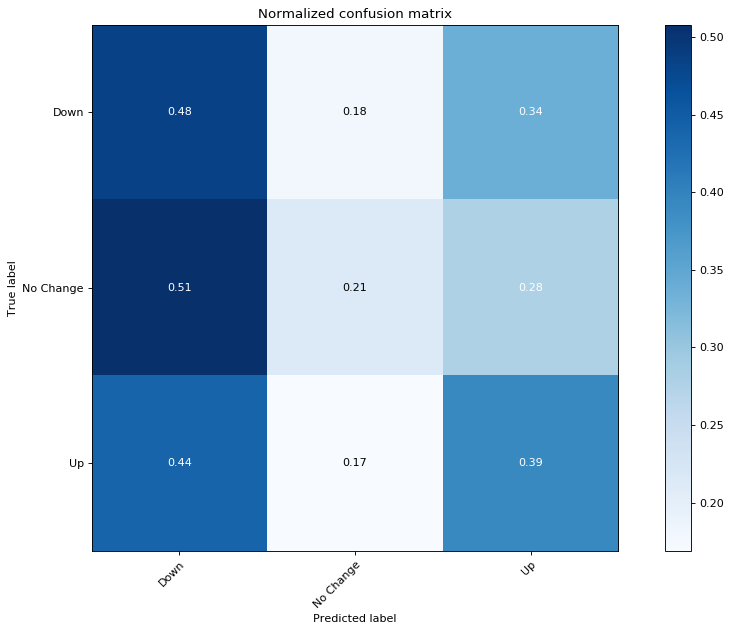

In [0]:
plot_confusion_matrix(y_true, predicted_classes, normalize=True)

### Mean Categorical Accuracy

In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, predicted_classes)

0.3758241758241758

### Export to CSV

In [0]:
y_true = np.insert(y_true, 0, 0)
predicted_classes = np.insert(predicted_classes, 0, 0)

In [0]:
columns = ['Date', 'True Closing Values', 'Predicted Closing Values', 'True Values', 'Predicted Values']
data = np.array([dates, original_data, predicted, y_true, predicted_classes]).T

In [0]:
csv = pd.DataFrame(data, columns=columns)

csv.to_csv('bi_lstm_first_half.csv', index=False)

## Download Files

In [0]:
from google.colab import files

files.download('bi_lstm_first_half.csv')

files.download('bi_lstm_first_half.h5')

## Second Half

### Load Data

In [0]:
x_train_2, y_train_2, x_test_2, y_test_2, scalars_2, original_data_2, dates_2 = load_data(df.values[int(len(df)/2):], seq_len, all_data[int(len(df)/2):])

TPU = 8

index = int(x_test_2.shape[0]/TPU)*TPU
x_test_2 = x_test_2[:index,:,:]
y_test_2 = y_test_2[:index]
original_data_2 = original_data_2[:index]
dates_2 = dates_2[:index]

print(x_train_2.shape)
print(y_train_2.shape)

(1827, 30, 16)
(1827,)


### Create Model

In [0]:
model_2 = create_model(x_train_2)

INFO:tensorflow:Querying Tensorflow master (grpc://10.7.246.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 7456853519070713707)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14558934335835245626)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7541544238226734802)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15440706205147677990)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 17528447551500237016)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

### Train Model

In [0]:
callbacks_list = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
]

history = model_2.fit(x_train_2,
                      y_train_2,
                      batch_size=60*TPU,
                      epochs=5000,
                      shuffle=True,
                      callbacks=callbacks_list,
                      validation_split=0.1,
                      verbose=1)

model_2.save('bi_lstm_second_half.h5')

Train on 1827 samples, validate on 183 samples
Epoch 1/5000
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(60,), dtype=tf.int32, name='core_id_90'), TensorSpec(shape=(60, 30, 16), dtype=tf.float32, name='input_5_10'), TensorSpec(shape=(60, 1), dtype=tf.float32, name='dense_4_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_5
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 282.9277882575989 secs
INFO:tensorflow:Setting weights on TPU model.
 960/1827 [==============>...............] - ETA: 7:29 - loss: 2.2494 INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(48,), dtype=tf.int32, name='core_id_90'), TensorSpec(shape=(48, 30, 16), dtype=tf.float32, name='input_5_10'), TensorSpec(shape=(48, 1), dtype=tf.float32, name='dense_4_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow

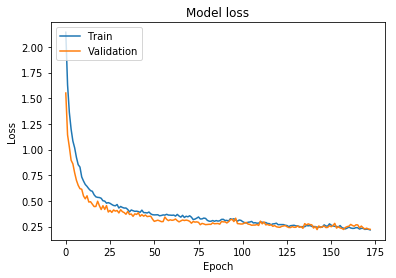

In [0]:
plot_loss(history)

### Predict for Test Set

In [0]:
predicted_2 = model_2.predict(x_test_2)

INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(4, 30, 16), dtype=tf.float32, name='input_5_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_5
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 601.1788082122803 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(1, 30, 16), dtype=tf.float32, name='input_5_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_5
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 325.9263610839844 secs


### Rescale Data

In [0]:
new_predicted_2 = []

for i in range(len(predicted_2)):
  temp = np.zeros((x_train_2.shape[2],))
  # 3 for closing price
  temp[3] = predicted_2[i]
  new_predicted_2.append(scalars_2[len(x_train_2)+i].inverse_transform(temp)[3])
  
predicted_2 = np.array(new_predicted_2)

### Plot Predictions

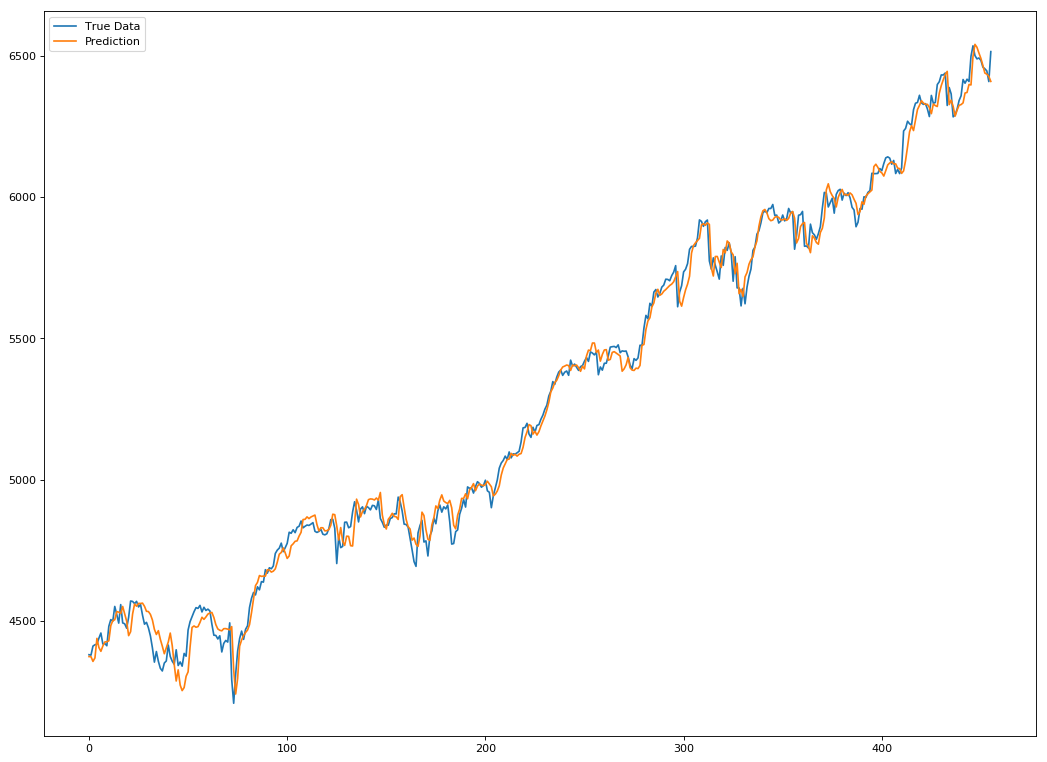

In [0]:
plot_results(predicted_2, original_data_2)

### Mean Squared Error

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(predicted_2, original_data_2)

2201.9260853035394

### Mean Absolute Percentage Error



In [0]:
print(np.mean(np.abs((original_data_2 - predicted_2) / original_data_2)) * 100)

0.6953771998375478


### Convert to Directional Data

In [0]:
predicted_directions_2 = directional_data(predicted_2, original_data_2)

No change: 256
Up: 114
Down: 85


In [0]:
actual_directions_2 = directional_data(original_data_2, original_data_2)

No change: 248
Up: 124
Down: 83


### Plot Confusion Matrix

In [0]:
classes = ["Down", "No Change", "Up"]
classes = np.array(classes)

indices = predicted_directions_2.argmax(axis=1)
predicted_classes_2 = classes[indices]

indices = actual_directions_2.argmax(axis=1)
y_true_2 = classes[indices]

By Count

Confusion matrix, without normalization
[[ 15  44  24]
 [ 50 149  49]
 [ 20  63  41]]


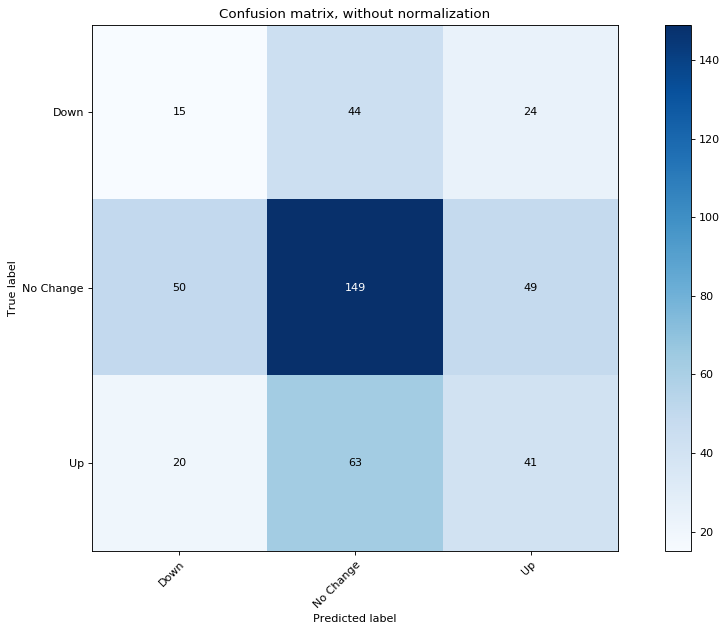

In [0]:
plot_confusion_matrix(y_true_2, predicted_classes_2, normalize=False)

Normalized

Normalized confusion matrix
[[0.18072289 0.53012048 0.28915663]
 [0.2016129  0.60080645 0.19758065]
 [0.16129032 0.50806452 0.33064516]]


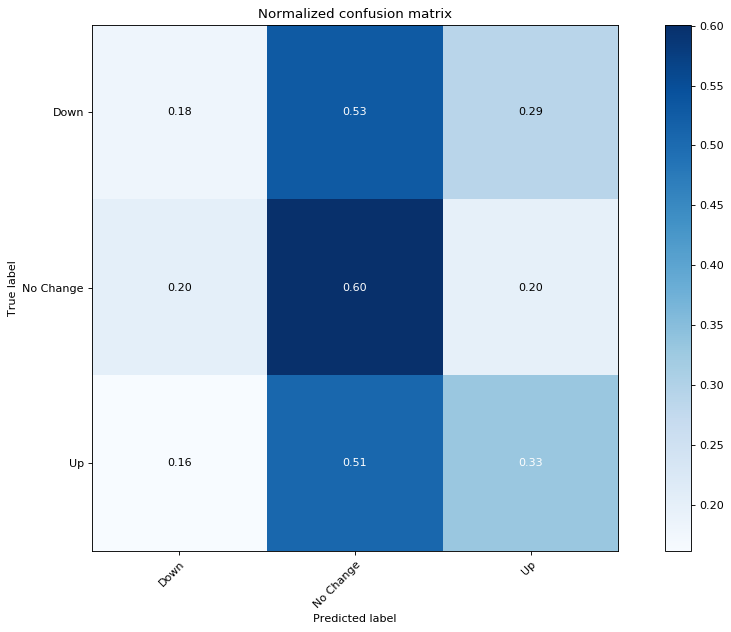

In [0]:
plot_confusion_matrix(y_true_2, predicted_classes_2, normalize=True)

### Mean Categorical Accuracy

In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true_2, predicted_classes_2)

0.45054945054945056

### Export to CSV

In [0]:
y_true_2 = np.insert(y_true_2, 0, 0)
predicted_classes_2 = np.insert(predicted_classes_2, 0, 0)

In [0]:
columns = ['Date', 'True Closing Values', 'Predicted Closing Values', 'True Values', 'Predicted Values']
data = np.array([dates_2, original_data_2, predicted_2, y_true_2, predicted_classes_2]).T

In [0]:
csv = pd.DataFrame(data, columns=columns)

csv.to_csv('bi_lstm_second_half.csv', index=False)

## Download Files

In [0]:
from google.colab import files

files.download('bi_lstm_second_half.csv')

files.download('bi_lstm_second_half.h5')

## Results

In [0]:
predicted_all = np.concatenate((predicted, predicted_2))

original_data_all = np.concatenate((original_data, original_data_2))

predicted_directions_all = np.concatenate((predicted_directions, predicted_directions_2))

actual_directions_all = np.concatenate((actual_directions, actual_directions_2))

### Mean Squared Error

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(predicted_all, original_data_all)

2297.077087728987

### Mean Absolute Percentage Error



In [0]:
print(np.mean(np.abs((original_data_all - predicted_all) / original_data_all)) * 100)

1.3923439783594813


### Plot Confusion Matrix

In [0]:
classes = ["Down", "No Change", "Up"]
classes = np.array(classes)

indices = predicted_directions_all.argmax(axis=1)
predicted_classes_all = classes[indices]

indices = actual_directions_all.argmax(axis=1)
y_true_all = classes[indices]

By Count

Confusion matrix, without normalization
[[ 94  73  79]
 [114 176  84]
 [ 93  91 106]]


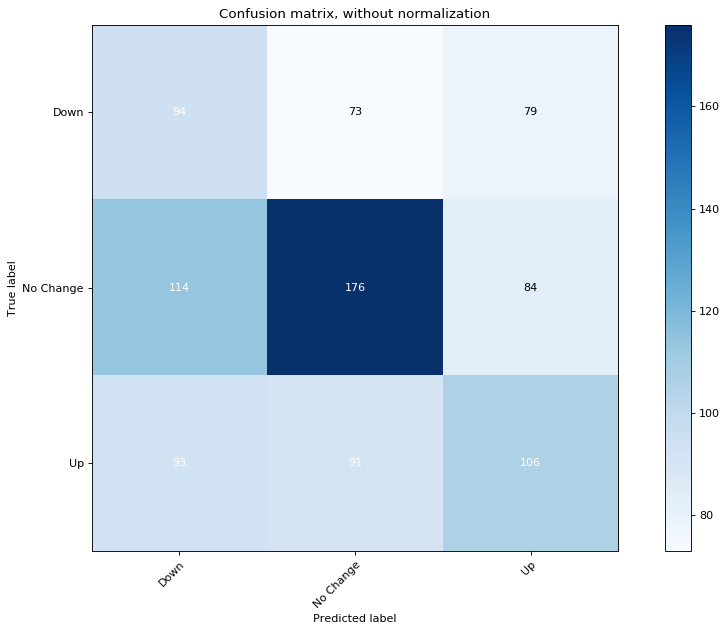

In [0]:
plot_confusion_matrix(y_true_all, predicted_classes_all, normalize=False)

Normalized

Normalized confusion matrix
[[0.38211382 0.29674797 0.32113821]
 [0.30481283 0.47058824 0.22459893]
 [0.32068966 0.3137931  0.36551724]]


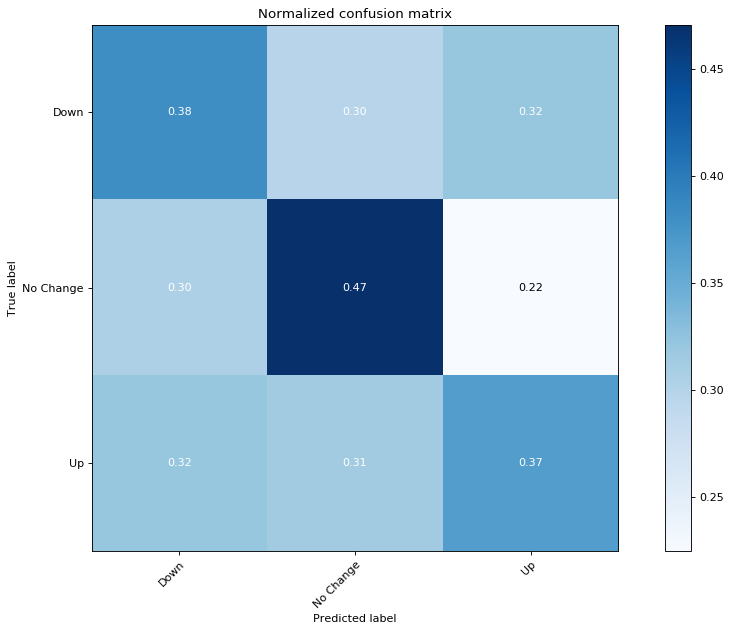

In [0]:
plot_confusion_matrix(y_true_all, predicted_classes_all, normalize=True)

### Mean Categorical Accuracy

In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true_all, predicted_classes_all)

0.41318681318681316